In [4]:
# matplotlib inline allows the display of matplotlib plots directly on the jupyter notebook
%matplotlib inline 
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [5]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [7]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [8]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [9]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [10]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [11]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [12]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [26]:
# Find the most recent date in the data set.
most_recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0] #querying in the measurement reference, ordering by desc, and getting first value
most_recent_date


'2017-08-23'

In [29]:
# Convert the most recent date to a datetime object
most_recent_datetime = dt.datetime.strptime(most_recent_date, '%Y-%m-%d')

In [30]:
# Get the names of columns in the measurement table
column_names_m = measurement.__table__.columns.keys()
print(column_names_m)

['id', 'station', 'date', 'prcp', 'tobs']


In [45]:
# Get the names of columns in the station table
column_names_s = station.__table__.columns.keys()
print(column_names_s)

['id', 'station', 'name', 'latitude', 'longitude', 'elevation']


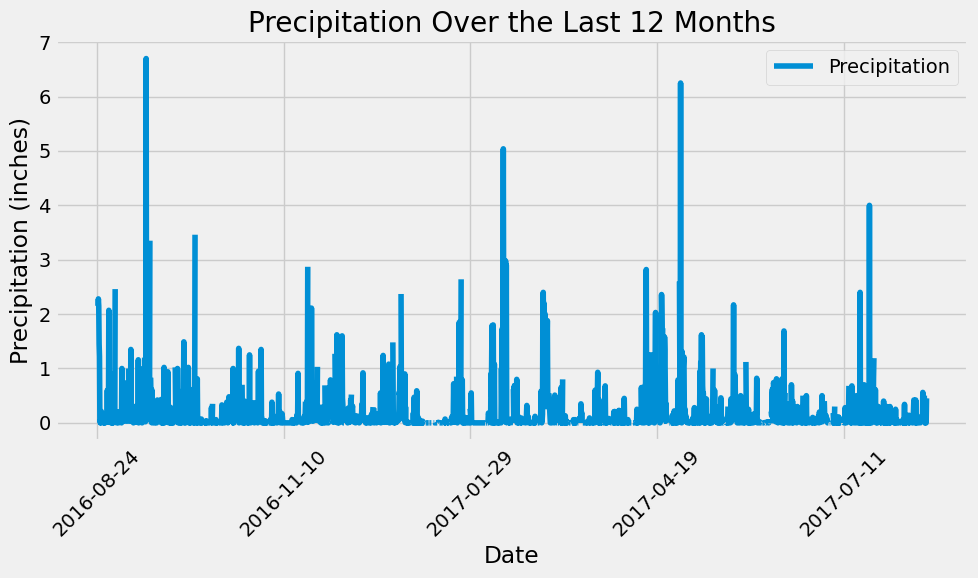

In [33]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database (most_recent_date variable)

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_datetime - dt.timedelta(days=365) # uses the value of the already obtained date and substracts 365 days to it.

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).filter(measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values('Date') #ensures that the data is in chronological order, which is important for plotting.

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x='Date', y='Precipitation', figsize=(10, 6))
plt.xlabel("Date")
plt.ylabel("Precipitation (inches)")
plt.title("Precipitation Over the Last 12 Months")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [42]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = df['Precipitation'].describe()
summary_statistics_df = pd.DataFrame(summary_statistics)
summary_statistics_df

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [52]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.id)).all() 
#if using scalar it would output the value directly instead of a tuple (as shown)
#total_stations = session.query(func.count(station.id)).scalar() 
total_stations


[(9,)]

In [56]:
# Design a query to find the most active stations
most_active_stations = session.query(measurement.station, func.count(measurement.station)).\
                        group_by(measurement.station).\
                        order_by(func.count(measurement.station).desc()).all()
#The func.count() function is used to count the occurrences of each station in the dataset.

# Print the list of stations and their row counts in descending order
print("Most active stations:")
most_active_stations

# Another way to do it:
#for station, row_count in most_active_stations:
#    print(station, row_count)



Most active stations:


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [81]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station_id = most_active_stations[0][0] # outputs 'USC00519281'

# Calculate the lowest, highest, and average temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
                    filter(measurement.station == most_active_station_id).first()

print(temperature_stats)
print(most_active_station_id)

(54.0, 85.0, 71.66378066378067)
USC00519281


In [70]:
# Query the most recent date of information available for the most active station
most_recent_date_station = session.query(func.max(measurement.date)).\
                            filter(measurement.station == most_active_station_id).scalar()

most_recent_date_station

#This was important since it's not the same date as we had stored in one_year_ago variable

'2017-08-18'

In [71]:
# Convert the most recent date of the station to a datetime object
most_recent_datetime_station = dt.datetime.strptime(most_recent_date_station, '%Y-%m-%d')

In [72]:
one_year_ago_station = most_recent_datetime_station - dt.timedelta(days=365) # uses the value of the already obtained date and substracts 365 days to it.

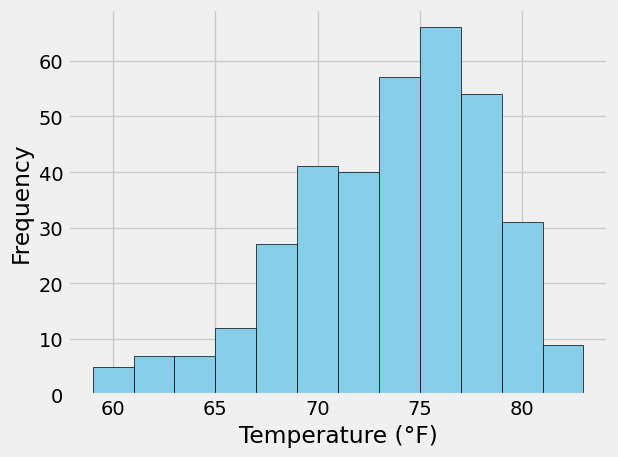

In [85]:
# Using the most active station id

# Query the last 12 months of temperature observation data for the most active station
temperature_data = session.query(measurement.tobs).\
                    filter(measurement.station == most_active_station_id).\
                    filter(measurement.date >= one_year_ago_station).\
                    filter(measurement.date < most_recent_datetime_station).all()

# Extract temperature observations into a list
temperatures = [temp[0] for temp in temperature_data]

# Plot the results as a histogram
plt.hist(temperatures, color='skyblue',bins=12, edgecolor='black')
plt.xlabel('Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

# Close Session

In [84]:
# Close Session
session.close()